In [1]:
%load_ext autoreload
%autoreload 2
import argparse
import logging
import torch
from torch.utils.data import DataLoader, Dataset
from pathlib import Path
from abc import ABC, abstractmethod
import torch.nn.functional as F
import os, json, datetime, sys
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import torch
import rasterio as rs
import matplotlib.pyplot as plt
sys.path.append("/home/hz477/declousion/baselines/UnCRtainTS/model")


# Import model classes
from dataloader import CRDataset
from benchmarking import BenchmarkEngine

ModuleNotFoundError: No module named 'baselines.UnCRtainTS'; 'baselines' is not a package

In [3]:
def plot_images(batch, batch_size=4):
    num_images = 3  # Number of images to plot
    
    for bid in range(batch_size):
        fig, axs = plt.subplots(3, num_images + 1, figsize=((num_images + 1) * 5, 15))  # Add one more column for the target
        for i in range(num_images):
            # Extract RGB channels for input images and normalize for visualization
            rgb_input = batch['input_images'][bid, i, [3, 2, 1], ...].detach().cpu().numpy()
            p2_input, p98_input = np.percentile(rgb_input, [20, 80])
            rgb_input = np.clip((rgb_input - p2_input) / (p98_input - p2_input), 0, 1)
            axs[0, i].imshow(np.transpose(rgb_input, (1, 2, 0)))
            axs[0, i].axis('off')
            axs[0, i].set_title(f'Input Image {i+1}', fontsize=20)
    
            # Binary maps for cloud masks
            cloud_mask = batch['cloud_masks'][bid, i, ...].detach().cpu().numpy().squeeze()
            axs[1, i].imshow(cloud_mask, cmap='gray', vmin=0, vmax=1)
            axs[1, i].axis('off')
            axs[1, i].set_title(f'Cloud Mask {i+1}', fontsize=20)
    
            # Binary maps for shadow masks
            shadow_mask = batch['shadow_masks'][bid, i, ...].detach().cpu().numpy().squeeze()
            axs[2, i].imshow(shadow_mask, cmap='gray', vmin=0, vmax=1)
            axs[2, i].axis('off')
            axs[2, i].set_title(f'Shadow Mask {i+1}', fontsize=20)
    
        # For the fourth column, first row, display the target image
        rgb_target = batch['target'][bid, [3, 2, 1], ...].detach().cpu().numpy()
        p2_target, p98_target = np.percentile(rgb_target, [5, 95])
        rgb_target = np.clip((rgb_target - p2_target) / (p98_target - p2_target), 0, 1)
        axs[0, num_images].imshow(np.transpose(rgb_target, (1, 2, 0)))
        axs[0, num_images].axis('off')
        axs[0, num_images].set_title(f'Target Image', fontsize=20)
    
        # Leave the rest of the fourth column empty
        for j in [1, 2]:
            axs[j, num_images].axis('off')

        plt.tight_layout()
        plt.show()


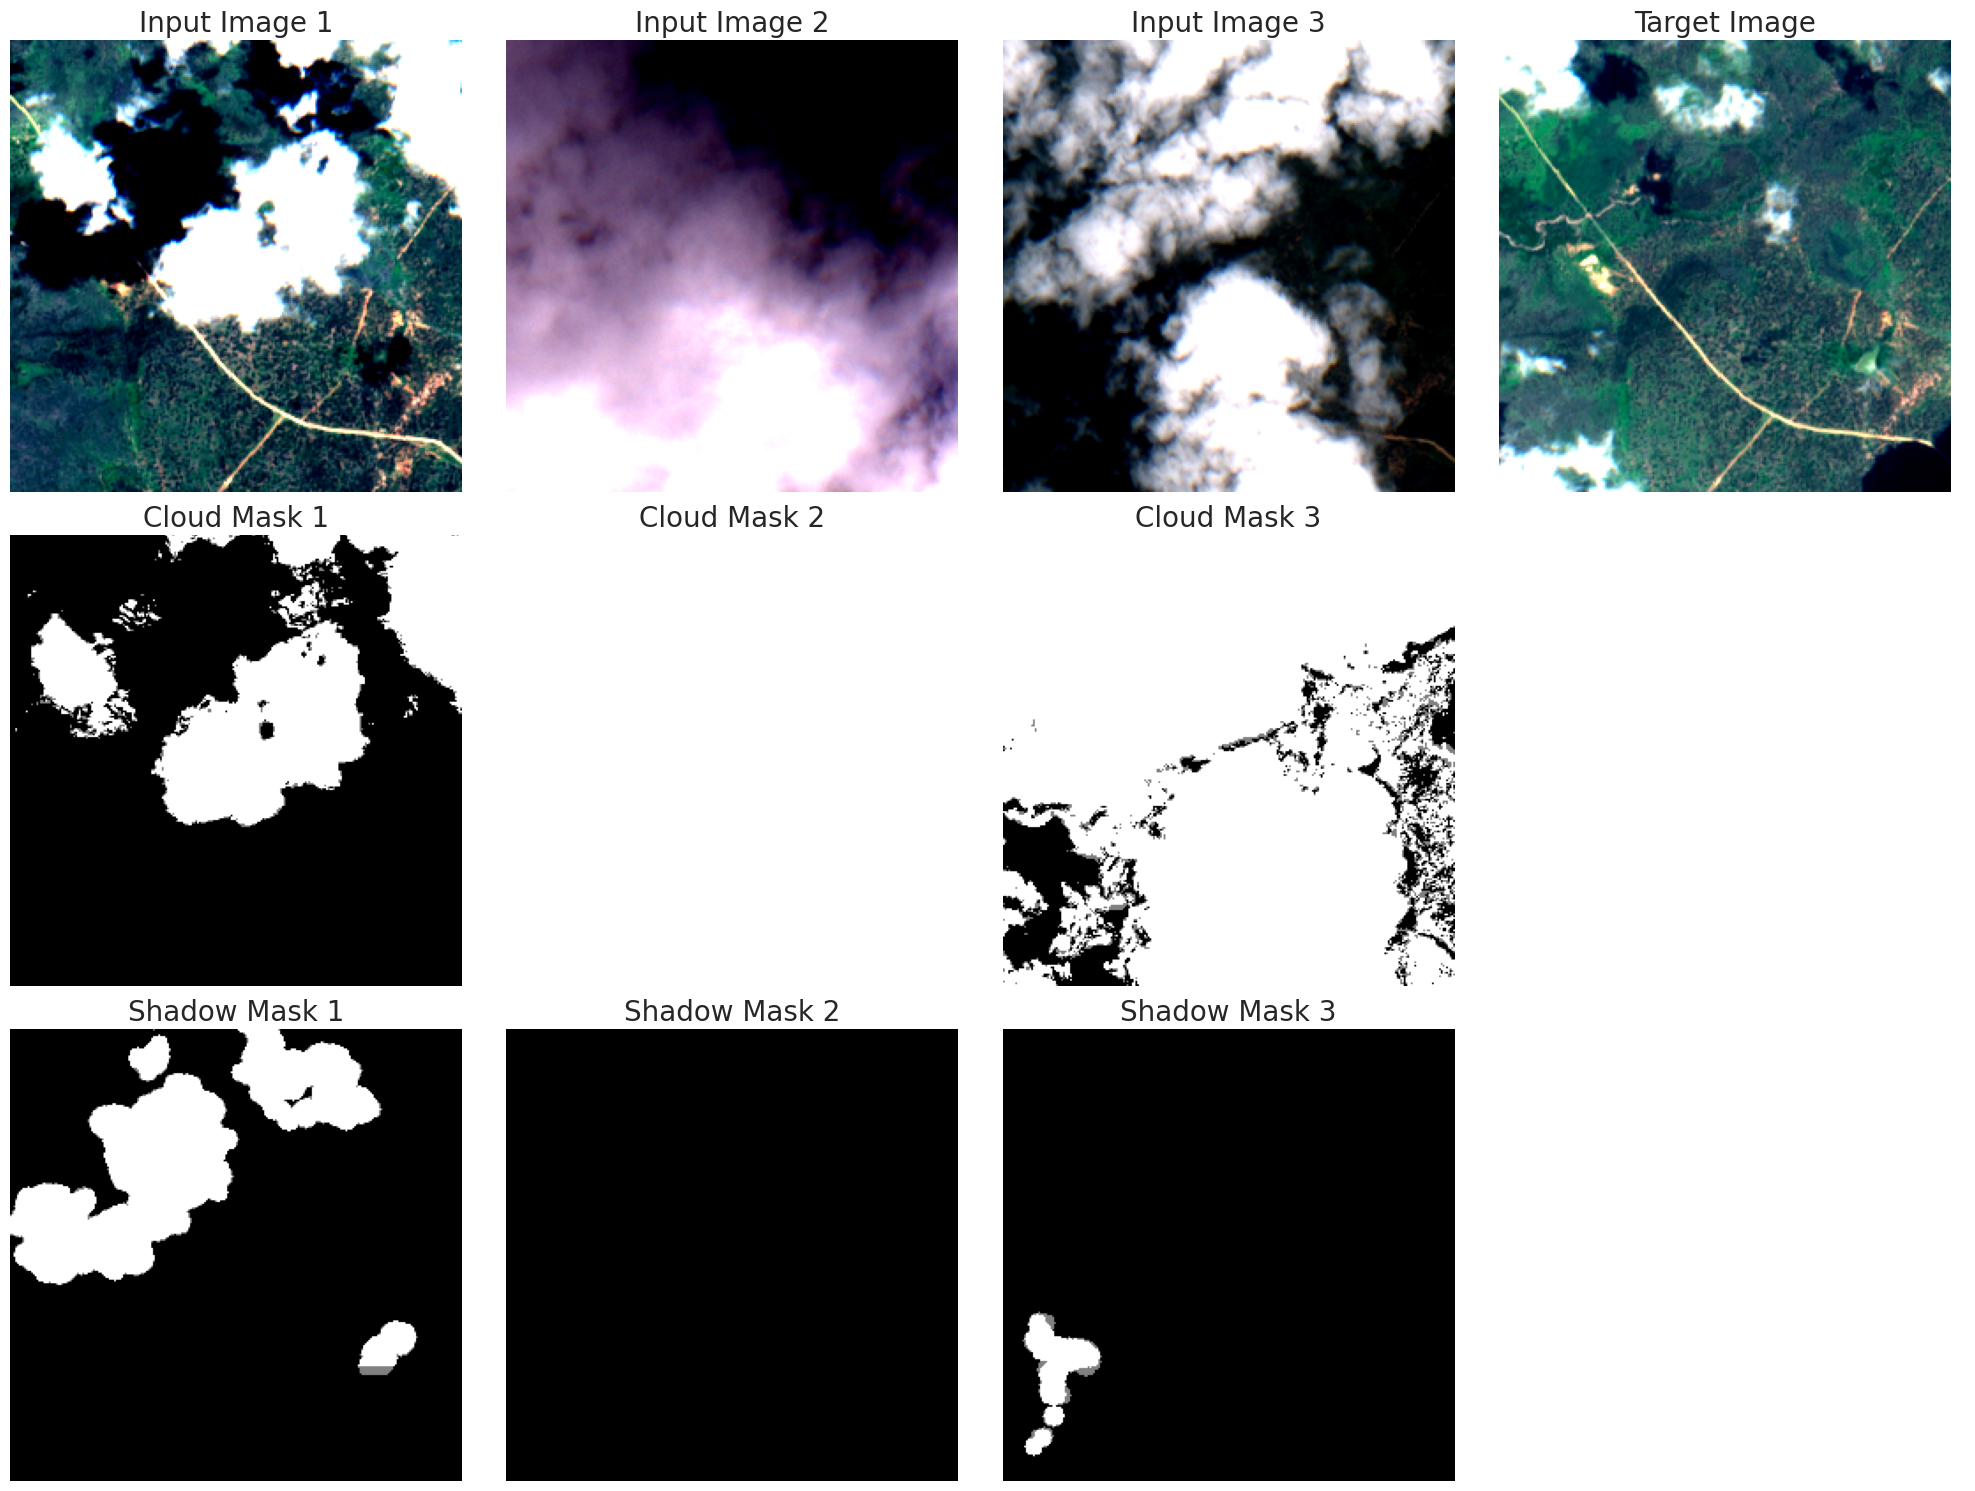

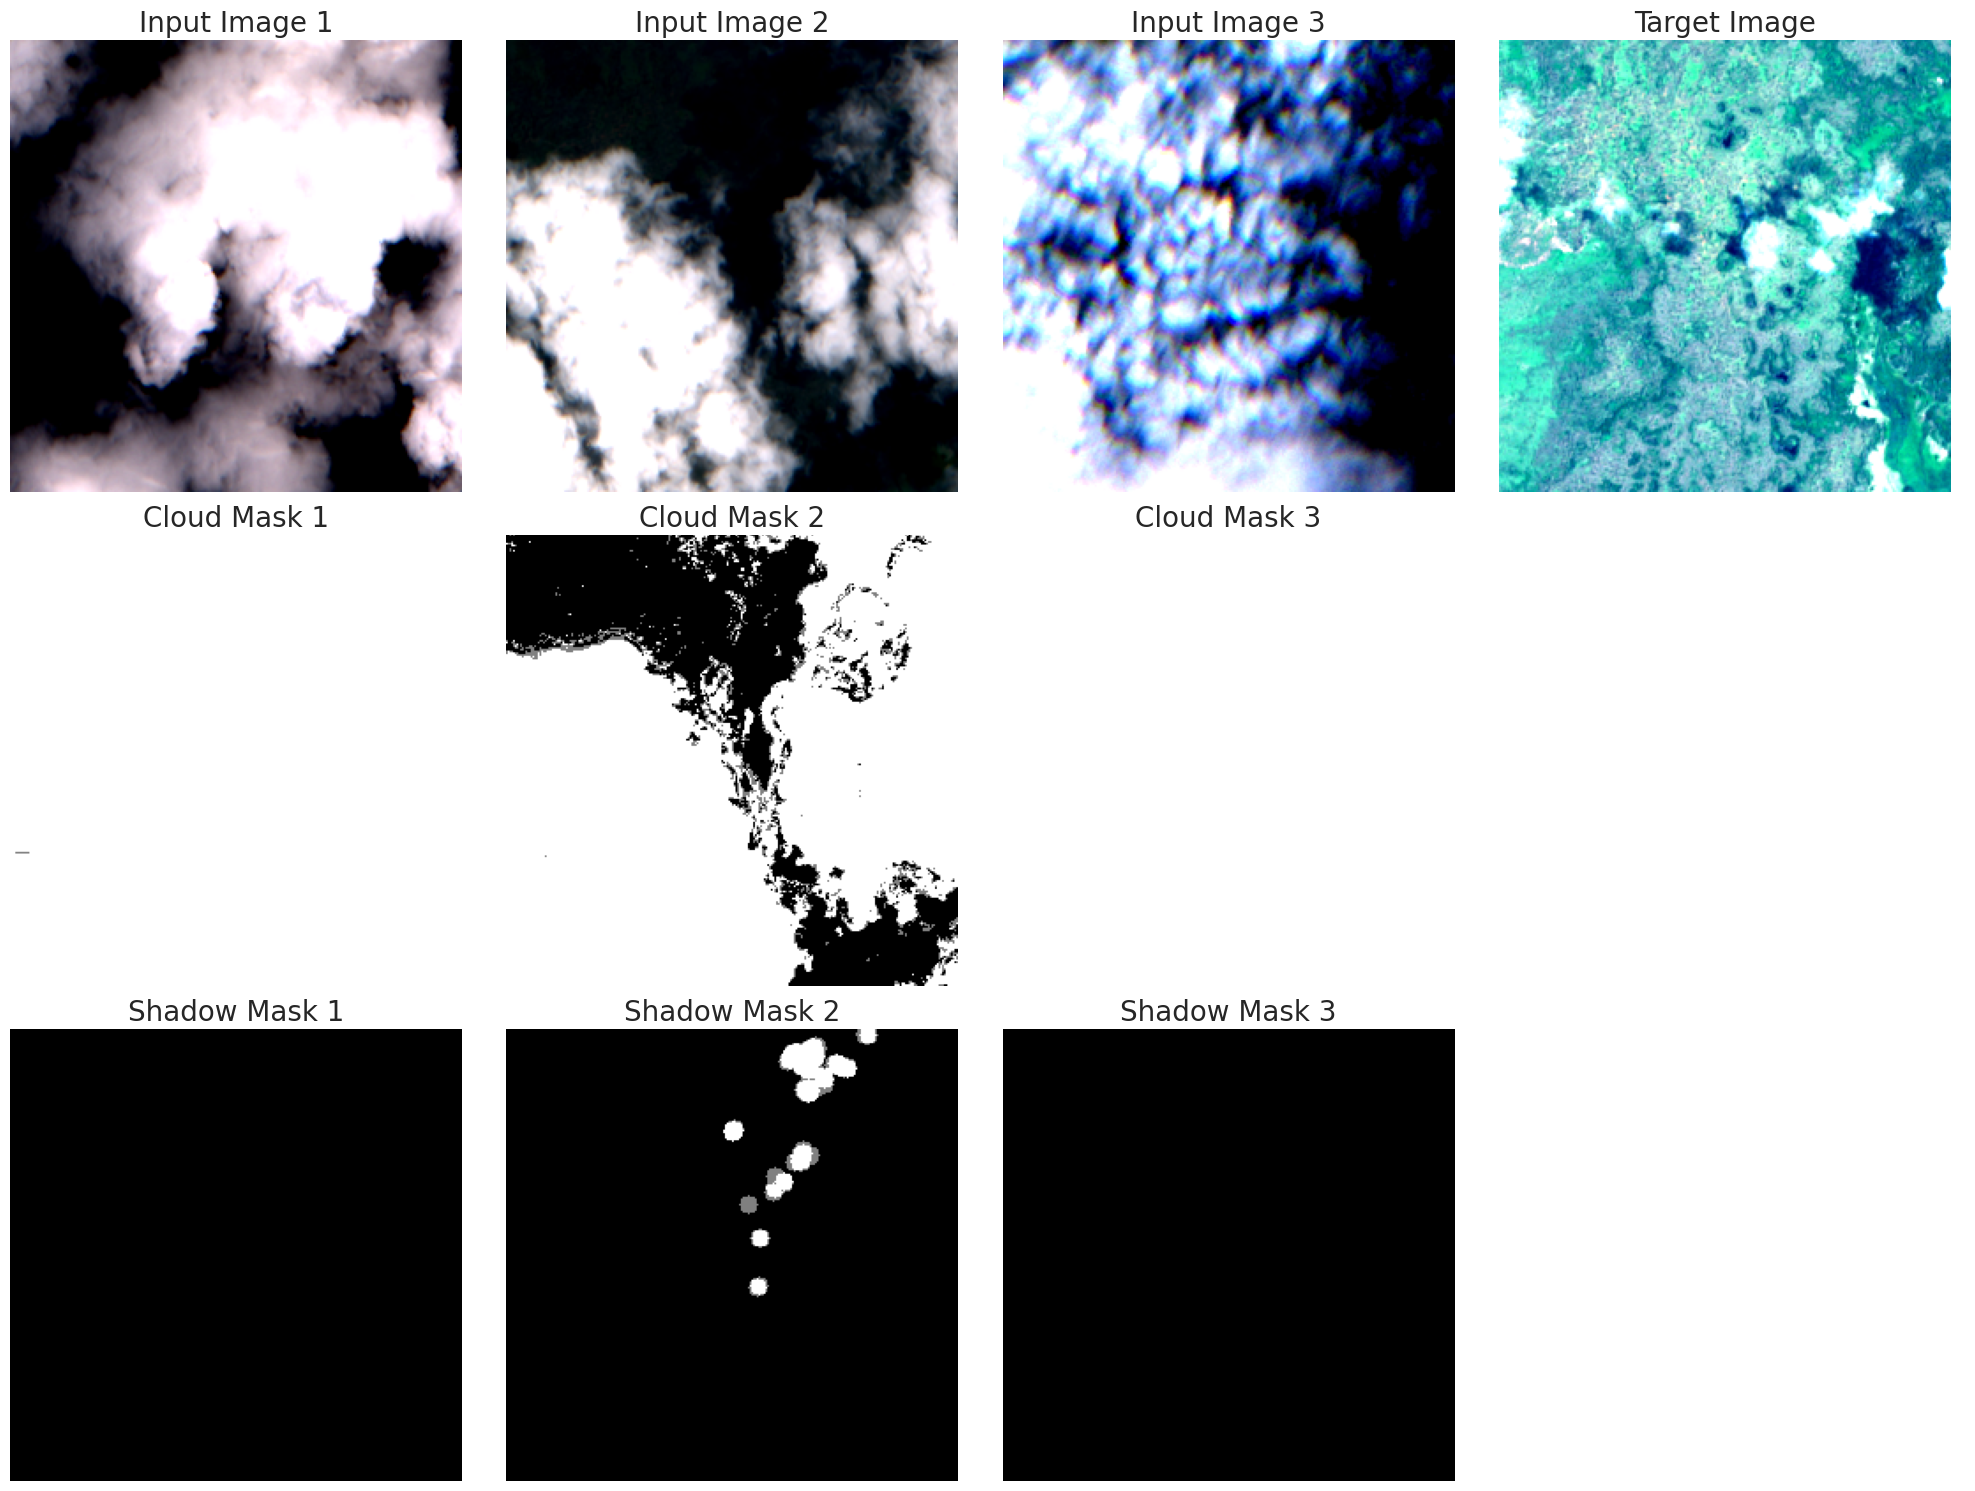

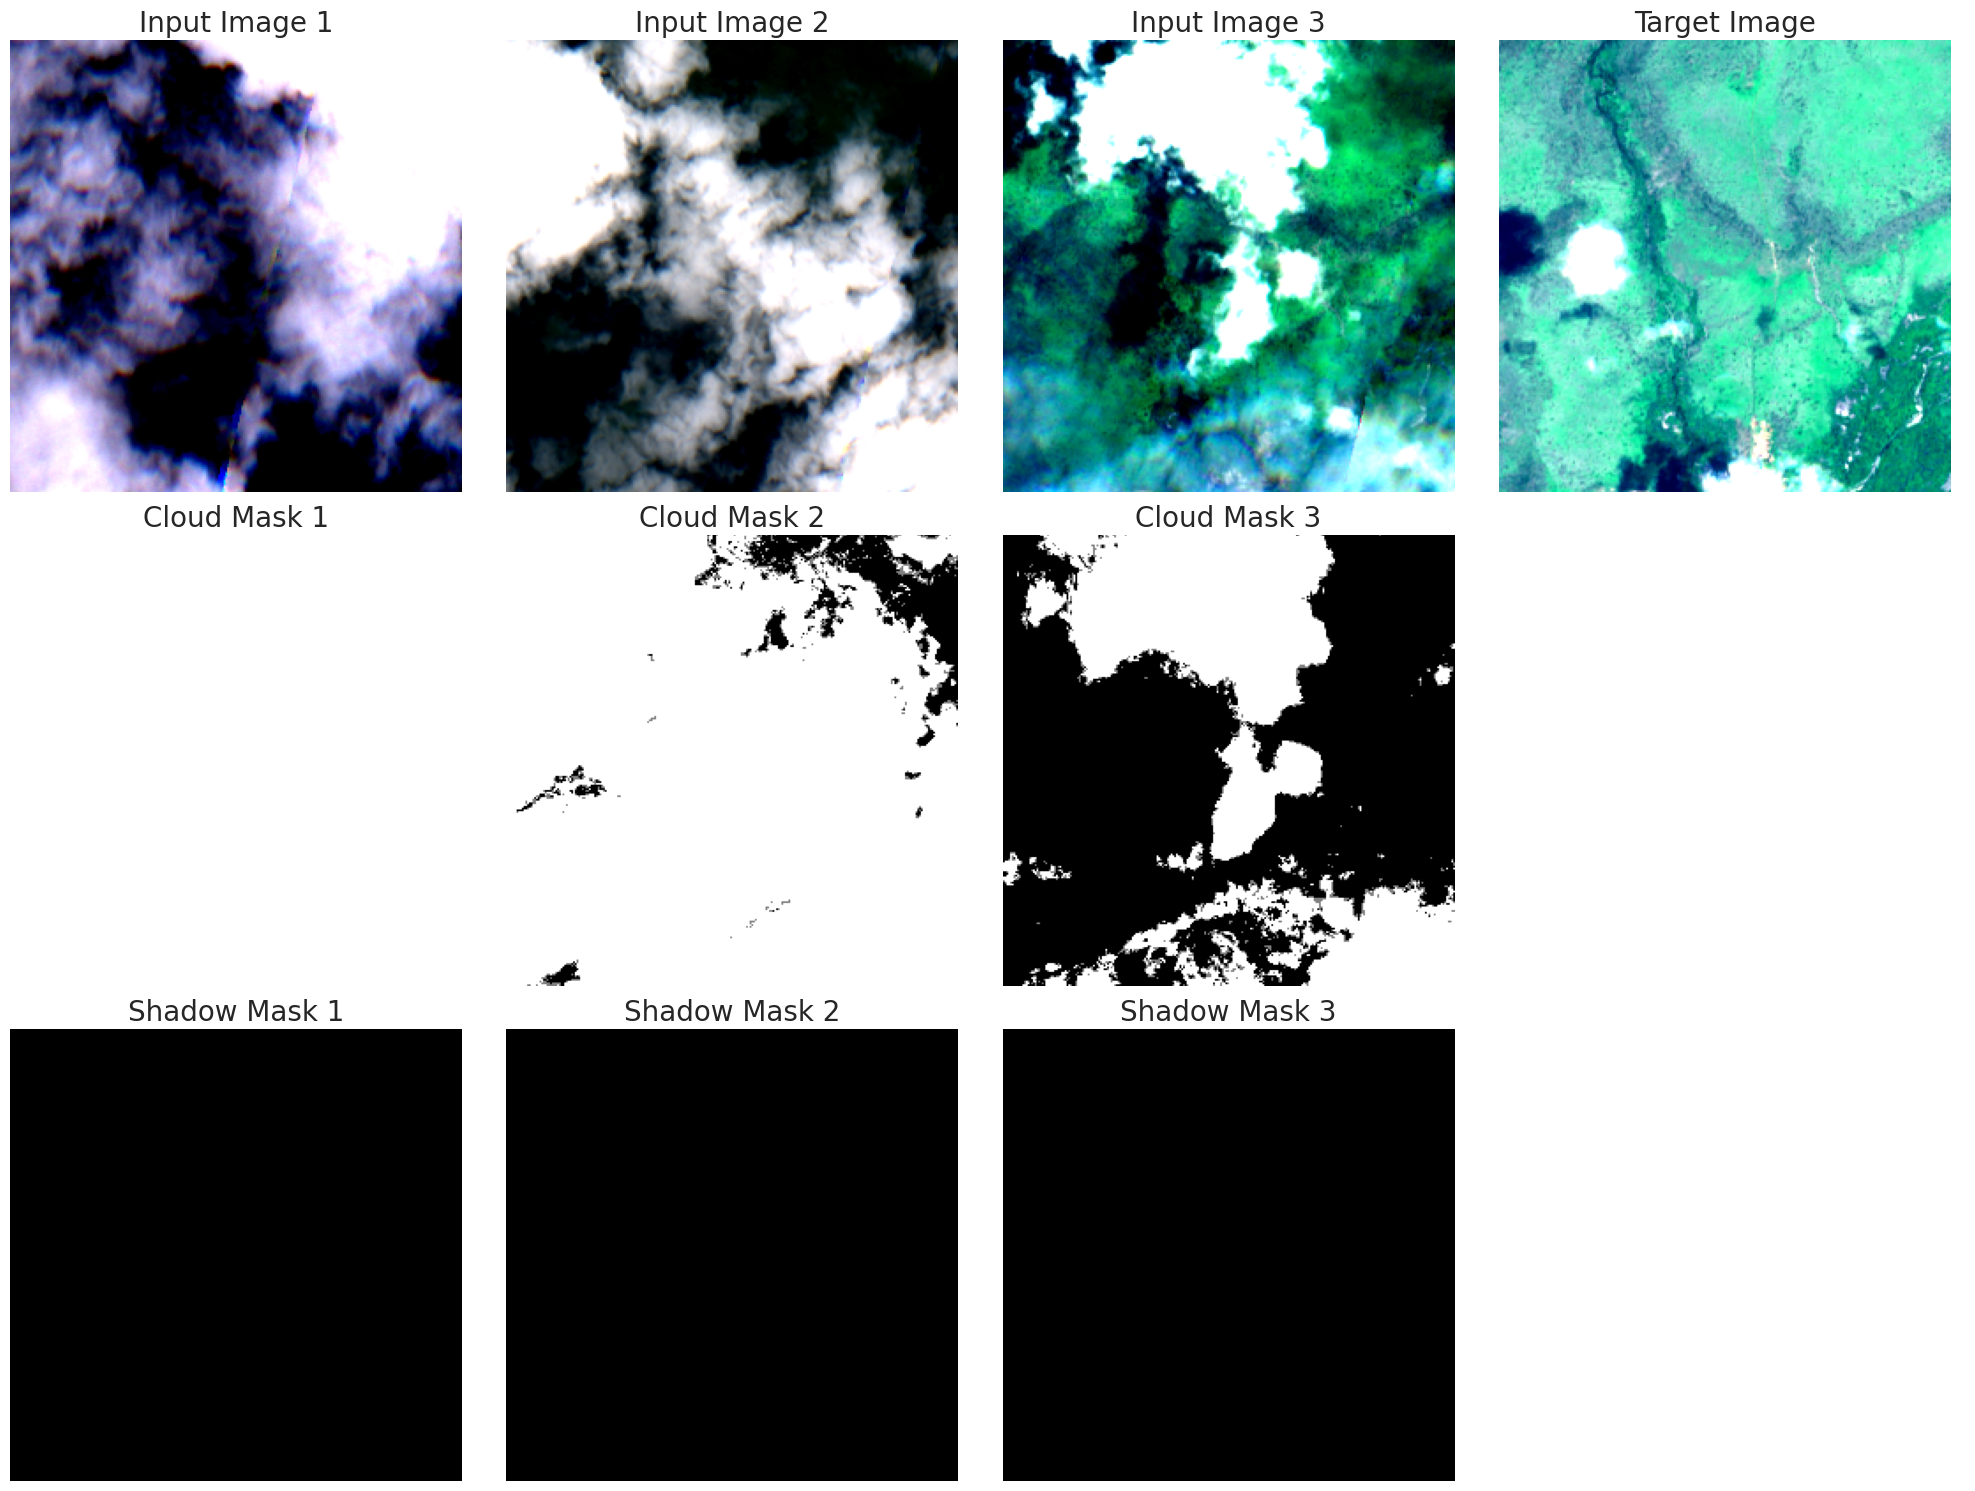

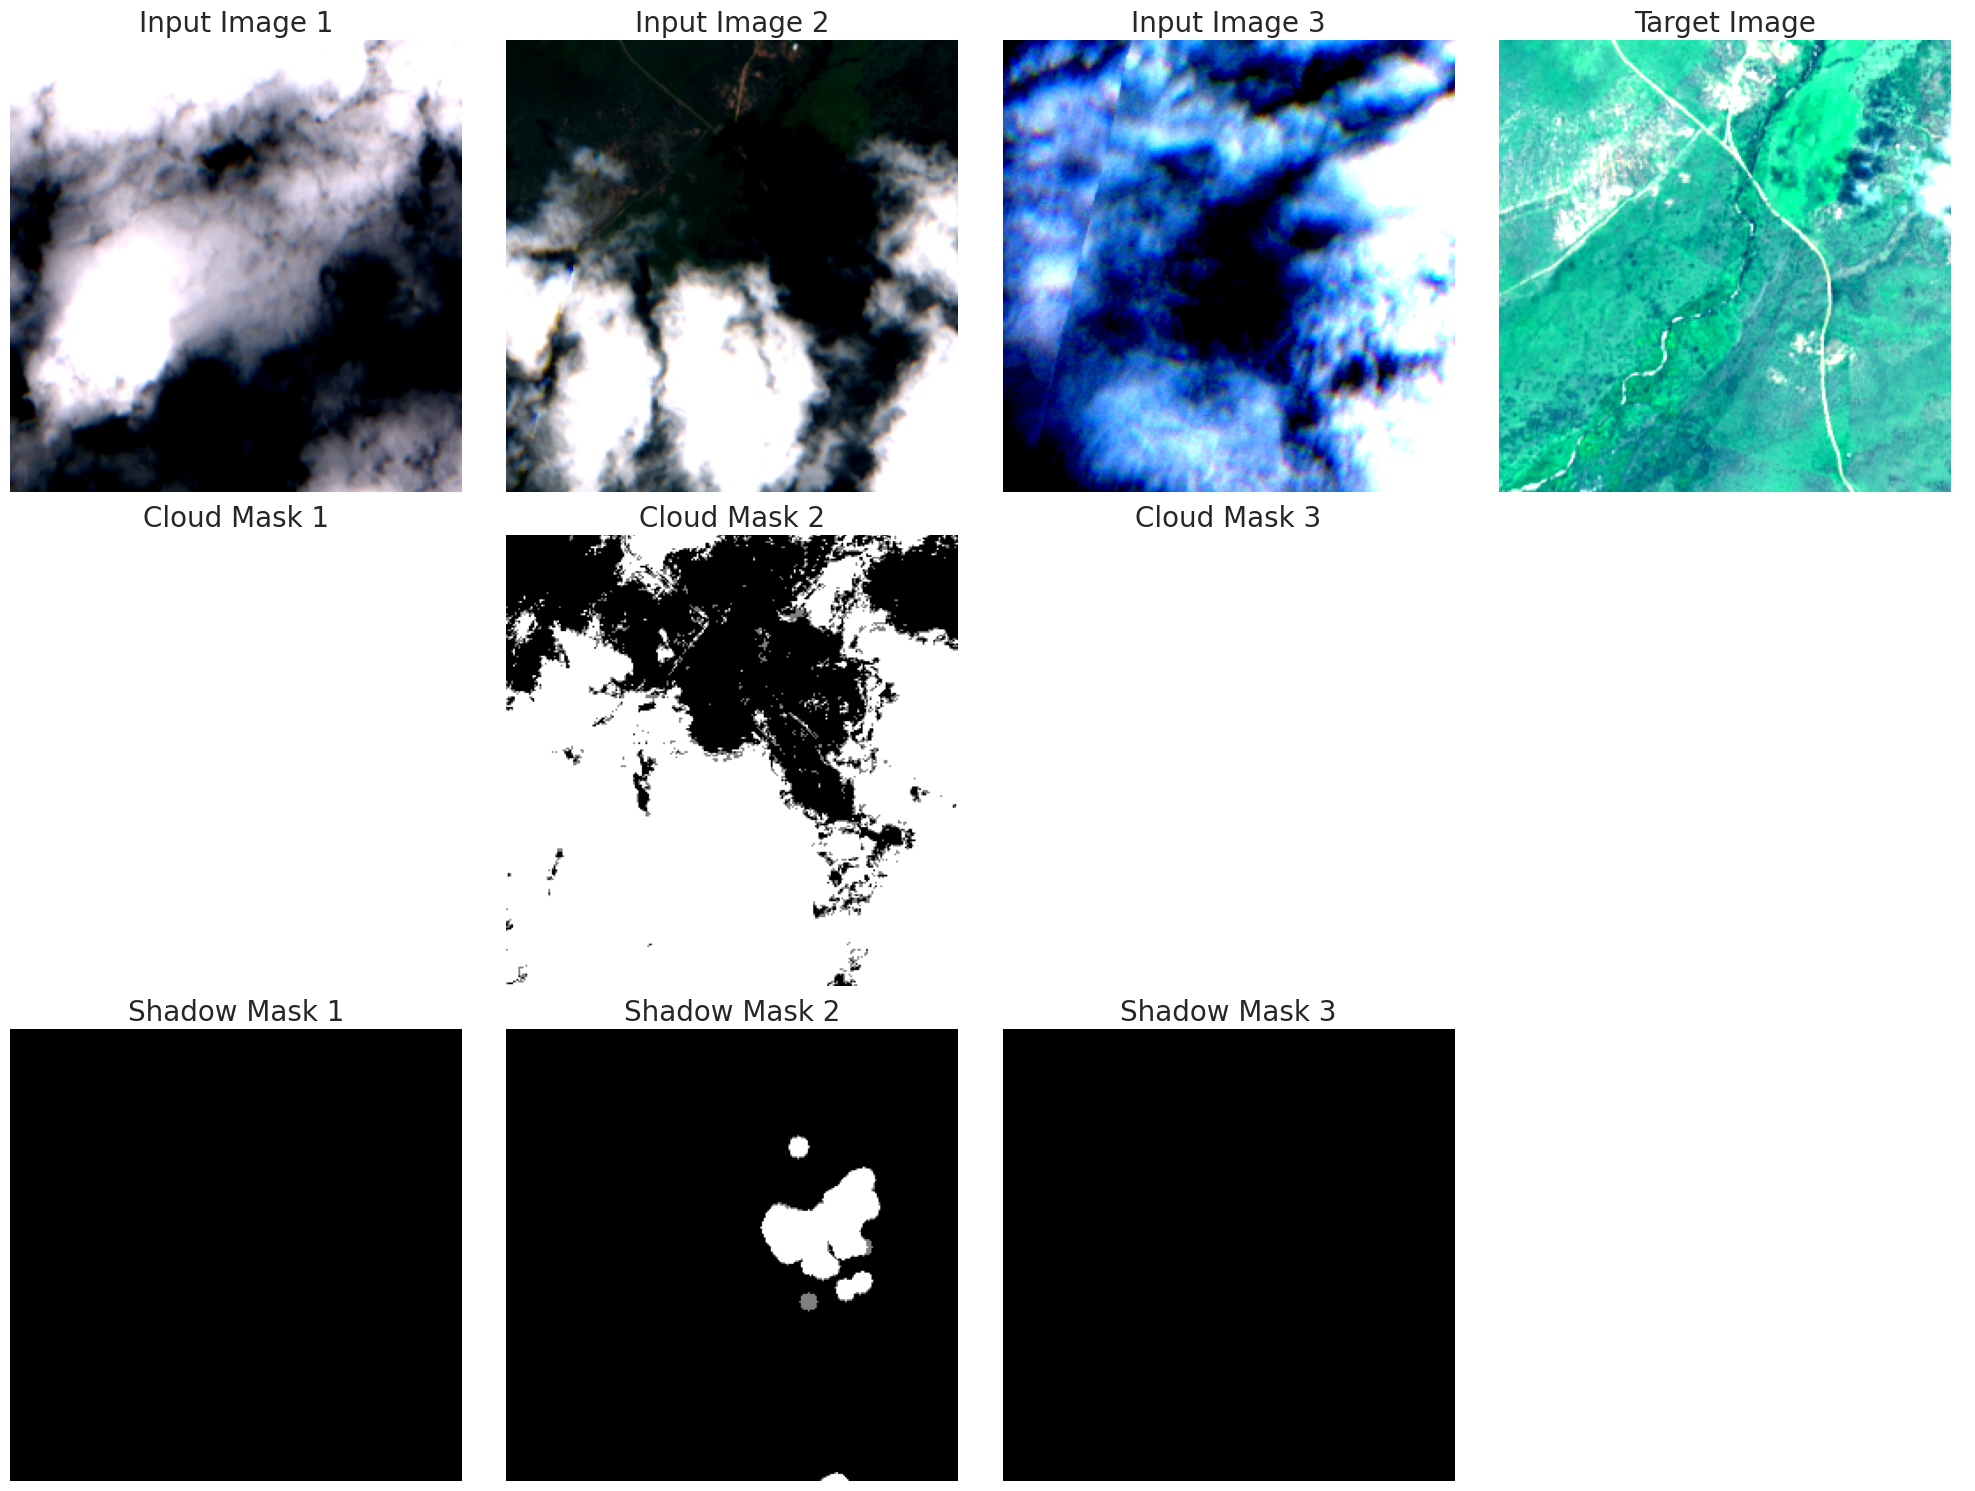

In [37]:
plot_images(x)

In [11]:
be = BenchmarkEngine(args)
outputs, targets = be.run()

Loading checkpoint /home/hz477/declousion/baselines/UnCRtainTS/results/noSAR_1/model.pth.tar
{'PSNR': tensor(14.1355), 'MAE': tensor(0.1528), 'RMSE': tensor(0.1964)}


In [219]:
outputs.shape, targets.shape

(torch.Size([117, 1, 13, 256, 256]), torch.Size([117, 1, 13, 256, 256]))

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image

def save_batch_visualization(batch, output, res_dir, timestamp, batch_id=0):
    # Ensure the results directory exists
    os.makedirs(res_dir, exist_ok=True)

    num_images = 3  # Number of input images
    fig, axs = plt.subplots(3, num_images + 1, figsize=((num_images + 1) * 5, 15))  # 4 columns, 3 rows

    for i in range(num_images):
        # Normalize and plot RGB input images
        rgb_input = batch['input_images'][batch_id, i, [3, 2, 1], ...].detach().cpu().numpy()
        p2_input, p98_input = np.percentile(rgb_input, [20, 80])
        rgb_input = np.clip((rgb_input - p2_input) / (p98_input - p2_input), 0, 1)
        axs[0, i].imshow(np.transpose(rgb_input, (1, 2, 0)))
        axs[0, i].axis('off')
        axs[0, i].set_title(f'Input Image {i+1}', fontsize=30)

        # Plot binary maps for cloud masks
        cloud_mask = batch['cloud_masks'][batch_id, i, ...].detach().cpu().numpy().squeeze()
        axs[1, i].imshow(cloud_mask, cmap='gray', vmin=0, vmax=1)
        axs[1, i].axis('off')
        axs[1, i].set_title(f'Cloud Mask {i+1}', fontsize=30)

        # Plot binary maps for shadow masks
        shadow_mask = batch['shadow_masks'][batch_id, i, ...].detach().cpu().numpy().squeeze()
        axs[2, i].imshow(shadow_mask, cmap='gray', vmin=0, vmax=1)
        axs[2, i].axis('off')
        axs[2, i].set_title(f'Shadow Mask {i+1}', fontsize=30)

    # Normalize and plot the target RGB image
    rgb_target = batch['target'][batch_id, [3, 2, 1], ...].detach().cpu().numpy()
    p2_target, p98_target = np.percentile(rgb_target, [5, 95])
    rgb_target = np.clip((rgb_target - p2_target) / (p98_target - p2_target), 0, 1)
    axs[0, num_images].imshow(np.transpose(rgb_target, (1, 2, 0)))
    axs[0, num_images].axis('off')
    axs[0, num_images].set_title(f'Target Image', fontsize=30)

    # Normalize and plot the output RGB image
    rgb_output = output[batch_id, [3, 2, 1], ...].numpy()
    p2_output, p98_output = np.percentile(rgb_output, [5, 95])
    rgb_output = np.clip((rgb_output - p2_output) / (p98_output - p2_output), 0, 1)
    axs[1, num_images].imshow(np.transpose(rgb_output, (1, 2, 0)))
    axs[1, num_images].axis('off')
    axs[1, num_images].set_title(f'Output Image', fontsize=30)

    # Leave the rest of the fourth column empty
    axs[2, num_images].axis('off')

    # Save the figure
    figure_filename = os.path.join(res_dir, f'visualization_{timestamp}_{batch_id}.png')
    plt.tight_layout()
    plt.savefig(figure_filename)
    plt.close()

    print(f"Saved visualization to {figure_filename}")


In [8]:
from PIL import Image
import numpy as np
import os
def normalize_image(tensor):
    # Normalize tensor to 0-255
    tensor_min = tensor.min()
    tensor_max = tensor.max()
    normalized_tensor = (tensor - tensor_min) / (tensor_max - tensor_min) * 255
    return normalized_tensor.astype(np.uint8)

def save_rgb_side_by_side(output, target, timestamp, res_dir):
    # Ensure the results directory exists
    os.makedirs(res_dir, exist_ok=True)

    # Assuming output and target are CHW tensors and channel order is [C, H, W]
    # Extract RGB channels
    output_rgb = output[[2, 1, 0], :, :]
    target_rgb = target[[2, 1, 0], :, :]

    # Normalize and convert PyTorch tensors to numpy arrays
    output_rgb_np = normalize_image(output_rgb.cpu().numpy()).transpose(1, 2, 0)
    target_rgb_np = normalize_image(target_rgb.cpu().numpy()).transpose(1, 2, 0)

    # Convert numpy arrays to PIL Images
    output_rgb_img = Image.fromarray(output_rgb_np)
    target_rgb_img = Image.fromarray(target_rgb_np)

    # Concatenate images horizontally (side by side)
    total_width = output_rgb_img.width + target_rgb_img.width
    max_height = max(output_rgb_img.height, target_rgb_img.height)
    combined_img = Image.new('RGB', (total_width, max_height))
    combined_img.paste(output_rgb_img, (0, 0))
    combined_img.paste(target_rgb_img, (output_rgb_img.width, 0))

    # Generate filename based on the timestamp
    combined_filename = os.path.join(res_dir, f'combined_rgb_{timestamp}.png')

    # Save the combined image as PNG
    combined_img.save(combined_filename, format='PNG')

    print(f"Saved combined RGB image to {combined_filename}")


In [6]:
S2_BANDS = 13
def create_parser(mode='train'):
    parser = argparse.ArgumentParser()
    # model parameters
    parser.add_argument(
        "--model",
        default='uncrtaints', # e.g. 'unet', 'utae', 'uncrtaints',
        type=str,
        help="Type of architecture to use. Can be one of: (utae/unet3d/fpn/convlstm/convgru/uconvlstm/buconvlstm)",
    )
    parser.add_argument("--experiment_name", default='my_first_experiment', help="Name of the current experiment",)

    # fast switching between default arguments, depending on train versus test mode
    if mode=='train':
        parser.add_argument("--res_dir", default="./results", help="Path to where the results are stored, e.g. ./results for training or ./inference for testing",)
        parser.add_argument("--plot_every", default=-1, type=int, help="Interval (in items) of exporting plots at validation or test time. Set -1 to disable")
        parser.add_argument("--export_every", default=-1, type=int, help="Interval (in items) of exporting data at validation or test time. Set -1 to disable")
        parser.add_argument("--resume_at", default=0, type=int, help="Epoch to resume training from (may re-weight --lr in the optimizer) or epoch to load checkpoint from at test time")
    elif mode=='test':
        parser.add_argument("--res_dir", default="./inference", type=str, help="Path to directory where results are written.")
        parser.add_argument("--plot_every", default=-1, type=int, help="Interval (in items) of exporting plots at validation or test time. Set -1 to disable")
        parser.add_argument("--export_every", default=1, type=int, help="Interval (in items) of exporting data at validation or test time. Set -1 to disable")
        parser.add_argument("--resume_at", default=-1, type=int, help="Epoch to load checkpoint from and run testing with (use -1 for best on validation split)")

    parser.add_argument("--encoder_widths", default="[128]", type=str, help="e.g. [64,64,64,128] for U-TAE or [128] for UnCRtainTS")
    parser.add_argument("--decoder_widths", default="[128,128,128,128,128]", type=str, help="e.g. [64,64,64,128] for U-TAE or [128,128,128,128,128] for UnCRtainTS")
    parser.add_argument("--out_conv", default=f"[{S2_BANDS}]", help="output CONV, note: if inserting another layer then consider treating normalizations separately")
    parser.add_argument("--mean_nonLinearity", dest="mean_nonLinearity", action="store_false", help="whether to apply a sigmoidal output nonlinearity to the mean prediction") 
    parser.add_argument("--var_nonLinearity", default="softplus", type=str, help="how to squash the network's variance outputs [relu | softplus | elu ]")
    parser.add_argument("--agg_mode", default="att_group", type=str, help="type of temporal aggregation in L-TAE module")
    parser.add_argument("--encoder_norm", default="group", type=str, help="e.g. 'group' (when using many channels) or 'instance' (for few channels)")
    parser.add_argument("--decoder_norm", default="batch", type=str, help="e.g. 'group' (when using many channels) or 'instance' (for few channels)")
    parser.add_argument("--block_type", default="mbconv", type=str, help="type of CONV block to use [residual | mbconv]")
    parser.add_argument("--padding_mode", default="reflect", type=str)
    parser.add_argument("--pad_value", default=0, type=float)

    # attention-specific parameters
    parser.add_argument("--n_head", default=16, type=int, help="default value of 16, 4 for debugging")
    parser.add_argument("--d_model", default=256, type=int, help="layers in L-TAE, default value of 256")
    parser.add_argument("--positional_encoding", dest="positional_encoding", action="store_false", help="whether to use positional encoding or not") 
    parser.add_argument("--d_k", default=4, type=int)
    parser.add_argument("--low_res_size", default=32, type=int, help="resolution to downsample to")
    parser.add_argument("--use_v", dest="use_v", action="store_true", help="whether to use values v or not")

    # set-up parameters
    parser.add_argument("--num_workers", default=0, type=int, help="Number of data loading workers")
    parser.add_argument("--rdm_seed", default=1, type=int, help="Random seed")
    parser.add_argument("--device",default="cuda",type=str,help="Name of device to use for tensor computations (cuda/cpu)",)
    parser.add_argument("--display_step", default=10, type=int, help="Interval in batches between display of training metrics",)

    # training parameters
    parser.add_argument("--loss", default="MGNLL", type=str, help="Image reconstruction loss to utilize [l1|l2|GNLL|MGNLL].")
    parser.add_argument("--resume_from", dest="resume_from", action="store_true", help="resume training acc. to JSON in --experiment_name and *.pth chckp in --trained_checkp")
    parser.add_argument("--unfreeze_after", default=0, type=int, help="When to unfreeze ALL weights for training")
    parser.add_argument("--epochs", default=20, type=int, help="Number of epochs to train")
    parser.add_argument("--batch_size", default=4, type=int, help="Batch size")
    parser.add_argument("--chunk_size", type=int, help="Size of vmap batches, this can be adjusted to accommodate for additional memory needs")
    parser.add_argument("--lr", default=1e-2, type=float, help="Learning rate, e.g. 0.01")
    parser.add_argument("--gamma", default=1.0, type=float, help="Learning rate decay parameter for scheduler")
    parser.add_argument("--val_every", default=1, type=int, help="Interval in epochs between two validation steps.")
    parser.add_argument("--val_after", default=0, type=int, help="Do validation only after that many epochs.")

    # flags specific to SEN12MS-CR and SEN12MS-CR-TS
    parser.add_argument("--use_sar", dest="use_sar", action="store_true", help="whether to use SAR or not")
    parser.add_argument("--pretrain", dest="pretrain", action="store_true", help="whether to perform pretraining on SEN12MS-CR or training on SEN12MS-CR-TS") 
    parser.add_argument("--input_t", default=3, type=int, help="number of input time points to sample, unet3d needs at least 4 time points")
    parser.add_argument("--ref_date", default="2014-04-03", type=str, help="reference date for Sentinel observations")
    parser.add_argument("--sample_type", default="cloudy_cloudfree", type=str, help="type of samples returned [cloudy_cloudfree | generic]")
    parser.add_argument("--vary_samples", dest="vary_samples", action="store_false", help="whether to sample different time points across epochs or not") 
    parser.add_argument("--min_cov", default=0.0, type=float, help="The minimum cloud coverage to accept per input sample at train time. Gets overwritten by --vary_samples")
    parser.add_argument("--max_cov", default=1.0, type=float, help="The maximum cloud coverage to accept per input sample at train time. Gets overwritten by --vary_samples")
    parser.add_argument("--root1", default='/home/hz477/declousion/data/SEN12MSCRTS', type=str, help="path to your copy of SEN12MS-CR-TS")
    parser.add_argument("--root2", default='/home/hz477/declousion/data/SEN12MSCRTS', type=str, help="path to your copy of SEN12MS-CR-TS validation & test splits")
    parser.add_argument("--root3", default='/home/hz477/declousion/data/SEN12MSCR', type=str, help="path to your copy of SEN12MS-CR for pretraining")
    parser.add_argument("--precomputed", default='/home/code/UnCRtainTS/util/precomputed', type=str, help="path to pre-computed cloud statistics")
    parser.add_argument("--region", default="all", type=str, help="region to (sub-)sample ROI from [all|africa|america|asiaEast|asiaWest|europa]")
    parser.add_argument("--max_samples_count", default=int(1e9), type=int, help="count of data (sub-)samples to take")
    parser.add_argument("--max_samples_frac", default=1.0, type=float, help="fraction of data (sub-)samples to take")
    parser.add_argument("--profile", dest="profile", action="store_true", help="whether to profile code or not") 
    parser.add_argument("--trained_checkp", default="", type=str, help="Path to loading a pre-trained network *.pth file, rather than initializing weights randomly")

    # flags specific to uncertainty modeling
    parser.add_argument("--covmode", default='diag', type=str, help="covariance matrix type [uni|iso|diag].")
    parser.add_argument("--scale_by", default=1.0, type=float, help="rescale data within model, e.g. to [0,10]")
    parser.add_argument("--separate_out", dest="separate_out", action="store_true", help="whether to separately process mean and variance predictions or in a shared layer")

    # flags specific for testing
    parser.add_argument("--weight_folder", type=str, default="/home/hz477/declousion/baselines/UnCRtainTS/results", help="Path to the main folder containing the pre-trained weights")
    parser.add_argument("--use_custom", dest="use_custom", action="store_true", help="whether to test on individually specified patches or not")
    parser.add_argument("--load_config", default='', type=str, help="path of conf.json file to load")
    parser.add_argument("-f", default='', type=str, help="path of conf.json file to load")


    return parser


def parse_arguments():
    parser = argparse.ArgumentParser(description="Benchmarking Engine for Models and Datasets")
    parser.add_argument("--baseline-base-path", type=str, required=True, help="Path to the baseline codebase")
    parser.add_argument("--data-path", type=str, required=True, help="Path to dataset")
    parser.add_argument("--metadata-path", type=str, required=True, help="Path to metadata file")
    parser.add_argument("--model-name", type=str, required=True, help="Model to use for benchmarking")
    parser.add_argument("--batch-size", type=int, default=4, help="Batch size for data loading")
    parser.add_argument("--num-workers", type=int, default=4, help="Number of workers for DataLoader")
    parser.add_argument("--data-split", type=str, default="train", help="Data split to use [train, val, test]")
    parser.add_argument("--device", type=str, required=True, help="Device to run the model on")
    parser.add_argument("--dataset-type", type=str, default="SEN12MS-CR", choices=["SEN12MS-CR", "SEN12MS-CR-TS"], help="Type of dataset")
    parser.add_argument("--input-t", type=int, default=3, help="Number of input time points (for time-series datasets)")
    parser.add_argument("--selected-rois", type=int, nargs="+", required=True, help="Selected ROIs for benchmarking")
    parser.add_argument("--time-span", type=int, default=3, help="Time span for the dataset")
    parser.add_argument("--cloud-percentage-range", type=int, nargs=2, default=[20, 30], help="Cloud percentage range for the dataset")
    parser.add_argument("--experiment-output-path", type=str, default="/share/hariharan/cloud_removal/results/baselines/uncrtaints/init", help="Path to save the experiment results")
    parser.add_argument("--save-plots", action="store_true", help="Save plots for the experiment")
    parser.add_argument("-f", default='', type=str, help="path of conf.json file to load")

    uc_args = parser.add_argument_group("UnCRtainTS Arguments")
    return parser

In [14]:
from baselines.UnCRtainTS.model.parse_args import create_parser



In [7]:
test_args = create_parser(mode='test').parse_args(['--experiment_name', 'noSAR_1'])
benchmark_args = parse_arguments().parse_args(['--baseline-base-path', '/home/hz477/declousion/baselines/UnCRtainTS', 
    '--data-path', '/share/hariharan/cloud_removal/metadata/split_temp/test_s2_2022_1-2022_12_patches_t3.csv', 
    '--metadata-path', '/share/hariharan/cloud_removal/metadata/patch_temp/test_s2_2022_1-2022_12_ts_cr_more_metadata.csv',
    '--model-name', 'uncrtaints',
    '--device', 'cuda:0',
    '--selected-rois', '0', '1', '14', '29',
    '--experiment-output-path', '/share/hariharan/cloud_removal/results/baselines/uncrtaints/init',
    '--save-plots'
])
args = argparse.Namespace(**{**vars(test_args), **vars(benchmark_args)})

In [8]:
args.selected_rois

[0, 1, 14, 29]

In [9]:
args.experiment_name

'noSAR_1'

In [13]:
be = BenchmarkEngine(args)
outputs, targets = be.run()

{'model': 'uncrtaints', 'encoder_widths': [128], 'decoder_widths': [128, 128, 128, 128, 128], 'out_conv': [26], 'mean_nonLinearity': True, 'var_nonLinearity': 'softplus', 'use_sar': False, 'agg_mode': 'att_group', 'encoder_norm': 'group', 'decoder_norm': 'batch', 'n_head': 16, 'd_model': 256, 'use_v': False, 'positional_encoding': True, 'd_k': 4, 'experiment_name': 'noSAR_1', 'lr': 0.001, 'gamma': 0.8, 'ref_date': '2014-04-03', 'pad_value': 0, 'padding_mode': 'reflect', 'val_every': 1, 'val_after': 0, 'pretrain': False, 'sample_type': 'cloudy_cloudfree', 'vary_samples': True, 'max_samples': 1000000000, 'input_size': 256, 'loss': 'MGNLL', 'covmode': 'diag', 'scale_by': 10.0, 'separate_out': False, 'resume_from': False, 'epochs': 20, 'res_dir': './inference', 'plot_every': -1, 'export_every': 1, 'resume_at': -1, 'device': 'cuda:0', 'display_step': 10, 'batch_size': 4, 'input_t': 3, 'min_cov': 0.0, 'max_cov': 1.0, 'root1': '/home/hz477/declousion/data/SEN12MSCRTS', 'root2': '/home/hz477/d

usage: ipykernel_launcher.py [-h] [--model MODEL]
                             [--experiment_name EXPERIMENT_NAME]
                             [--res_dir RES_DIR] [--plot_every PLOT_EVERY]
                             [--export_every EXPORT_EVERY]
                             [--resume_at RESUME_AT]
                             [--encoder_widths ENCODER_WIDTHS]
                             [--decoder_widths DECODER_WIDTHS]
                             [--out_conv OUT_CONV] [--mean_nonLinearity]
                             [--var_nonLinearity VAR_NONLINEARITY]
                             [--agg_mode AGG_MODE]
                             [--encoder_norm ENCODER_NORM]
                             [--decoder_norm DECODER_NORM]
                             [--block_type BLOCK_TYPE]
                             [--padding_mode PADDING_MODE]
                             [--pad_value PAD_VALUE] [--n_head N_HEAD]
                             [--d_model D_MODEL] [--positional_encoding]
     

SystemExit: 2

/home/hz477/miniconda3/envs/declousion/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


### Testing the dataloader

In [142]:
be = BenchmarkEngine(args)

Loading checkpoint /home/hz477/declousion/baselines/UnCRtainTS/results/noSAR_1/model.pth.tar


AttributeError: 'UNCRTAINTS' object has no attribute 'to'

In [22]:
args.f

AttributeError: 'Namespace' object has no attribute 'f'

In [ ]:
dataset = CRDataset(args.data_path, args.metadata_path, args.selected_rois, args.time_span, args.cloud_percentage_range)
dataloader = DataLoader(dataset, batch_size=args.batch_size, shuffle=False, num_workers=args.num_workers)
x = next(iter(dataloader))
for k in x.keys():
    print(k, x[k].shape)
dataset.data.head()